### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 12th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [1]:
import numdifftools as nd

# done in problem (9)...commented out because 'f_lnlaplace' is not defined yet
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy import optimize

## 1)

In [3]:
# Loading hw3_data_1.npy
data = np.load("../../homeworks/hw_data/hw3_data_1.npy") 
# extracting measurements and uncertainties
meas = np.array([i[0] for i in data])
uncert = np.array([i[1] for i in data])

# Using heteroscedastic gaussian result from derivation in Lecture 5 
# to calculate sample mean and error on sample mean 
sample_mu = np.sum(meas/uncert**2)/np.sum(1/uncert**2)
error = np.sum(1/uncert**2)**(-1/2)
print('sample mean: ',sample_mu)
print('error on sample mean:',error)

sample mean:  3.9179920346060557
error on sample mean: 0.09481084100510954


## 2)

In [4]:
# Writing ln-likelihood function for Gaussian distribution, following approach from Lecture 6
# For a Gaussian distribution, maximizing ln-likelihood is same as minimizing chi^2 (derivations in L5 & L6).
def squared_loss(mu, xi, sigma):
    # the only model parameter is mean value, a constant value
    return np.sum(((xi - mu) / sigma) ** 2, -1) # data minus model, weighted by the noise

# define a lambda function
f_squared = lambda beta: squared_loss(beta[0], xi=meas, sigma=uncert)

# compute the maximum likelihood 
beta0 = 4 # initial guess for mu
beta_squared = optimize.fmin(f_squared, beta0, disp=False) # scipy optimize finds the function minimum

print('Best fit mean: ',beta_squared[0])

Best fit mean:  3.91796875


## 3)

In [5]:
# computing Fisher uncertainty estimate on the mean, using numerical technique from Lecture_5
xgrid = np.linspace(1,8,1000) # make a list of possible mu values
sums = []
# probsum = []
for i in range(len(xgrid)):
    logpdf = norm.logpdf(meas,loc=xgrid[i],scale=uncert)
    sums.append(np.sum(logpdf)) # taking sum instead of product because we already took the log
#   can also find pdf and then take sum instead...gives the same result, but with a warning message. 
#     pdf = norm.pdf(meas,loc=xgrid[i],scale=uncert)
#     probsum.append(np.product(pdf))
L = np.array(sums) # can do 'probsum' for pdf case
    
sigma_mu = np.diff(L, n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.095


## 4)

In [6]:
import random
from random import choices

# function to generate 1000 bootstrap realizations of the dataset
def bootsp(mean,sigma,resample=1000):
    length = len(mean)
    mean_array,sigma_array = [],[]
    for i in range(resample):
        # sampling indices so that measurements & uncertainties stay paired together
        idxs = choices(np.arange(0,length,1),k=length)
        sample_mean = mean[idxs] 
        sample_sigma = sigma[idxs]
        # append each bootstrap realization of the data
        mean_array.append(sample_mean)
        sigma_array.append(sample_sigma)
    return mean_array,sigma_array

# generating 1000 bootstrap realizations of this dataset
bootstrap_means, bootstrap_sig  = bootsp(meas,uncert)

## 5)

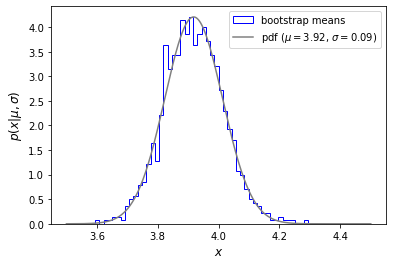

The histogram of bootstrap means agrees with the Gaussian pdf


In [7]:
boot_means = []
# using each bootstrap realization of the data, find the best-fit mean
# the mean is the model parameter, and we want to map the uncertainty of this parameter

for i in range(len(bootstrap_means)):
    # using the same procedure as problem (2)
    f_boot = lambda beta: squared_loss(beta, xi=bootstrap_means[i], sigma=bootstrap_sig[i])

    beta0 = 4 # initial guess for mu
    beta_squared = optimize.fmin(f_boot, beta0,disp=False)

    boot_means.append(beta_squared[0])

# plot a normalized histogram of the best-fit means from the different bootstrap realizations
x = np.linspace(3.5, 4.5, 1000)
dist = norm(sample_mu,error)
plt.hist(boot_means,bins=50,density=True,histtype='step',color='b',label='bootstrap means')
# overplot a Gaussian pdf with mean and std found in (1)
plt.plot(x,dist.pdf(x),c='gray',label=r'pdf ($\mu=$'+str(round(sample_mu,2))+r', $\sigma=$'+str(round(error,2))+')')
plt.xlabel(r'$x$',fontsize=12)
plt.ylabel(r'$p(x|\mu,\sigma)$',fontsize=12)
plt.legend(loc='upper right')
plt.show()
print('The histogram of bootstrap means agrees with the Gaussian pdf')

## 6)

In [8]:
# Defining ln-likelihood function for Laplace distribution 
from scipy.stats import laplace

def laplace_likelihood(mu, delta, xi):
    # here, the model parameters are mu and delta
    likelihood = laplace.logpdf(xi,loc=mu,scale=delta)
# reason for -ve sign: optimize finds the function minimum, but we want to maximize the ln-likelihood, not minimize it
    return -np.sum(likelihood)
# can also use this (almost like the laplace version of minimizing the chi^2)
#     return np.sum(abs(xi - mu)/delta - np.log(1/(2*delta))) # negative sign has been accounted for.

f_laplace = lambda beta: laplace_likelihood(beta[0], beta[1], xi=meas) # could put the -ve here instead

# compute the maximum likelihood 
beta0 = [4,1] # initial guess
beta_laplace = optimize.fmin(f_laplace, beta0, disp=False) 

print('best-fit loc. parameter: ',beta_laplace[0])
print('best-fit scale. parameter: ',beta_laplace[1])

best-fit loc. parameter:  4.088288159375196
best-fit scale. parameter:  0.8822692335377051


## 7)

In [9]:
# Finding the AIC values for the heteroscedastic Gaussian model and the Laplacian model
def AIC(L_0,k,N):
    aic = -2*L_0 + 2*k + 2*k*(k+1)/(N-k-1)
    return aic

# we take the negative here, because earlier we took the negative of our functions to use in optimize.fit 
# reason for taking -ve: the functions were designed to be minimized by scipy optimize,
# but we want the maximum ln-likelihood 
print('AIC for Gaussian: ',AIC(-squared_loss(beta_squared[0],meas,uncert), 1, len(meas)))
print('AIC for Laplacian: ',AIC(-laplace_likelihood(beta_laplace[0],meas,beta_laplace[1]), 2, len(meas)))
print('The model favored by the data is the Gaussian, because its AIC value is smaller.',
     '\nThis makes sense because the original data is Gaussian.')

AIC for Gaussian:  174.7883864769012
AIC for Laplacian:  596.8039962474634
The model favored by the data is the Gaussian, because its AIC value is smaller. 
This makes sense because the original data is Gaussian.


## 8)

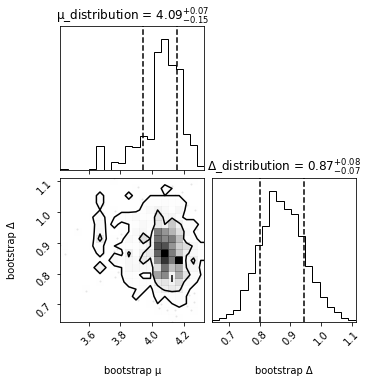

In [10]:
# similar to (5)
# using each bootstrap realization of the data, find the best-fit μ and Δ
bootlap_means = []
bootlap_delta = []
for i in range(len(bootstrap_means)):
    
    f_bootlaplace = lambda betaboot: laplace_likelihood(betaboot[0], betaboot[1], xi=bootstrap_means[i])
    
    # compute the maximum likelihood 
    beta0 = [4,1] # initial guess
    beta_bootlaplace = optimize.fmin(f_bootlaplace, beta0, disp=False)
    # record best-fit μ/Δ from the different bootstrap realizations
    bootlap_means.append(beta_bootlaplace[0])
    bootlap_delta.append(beta_bootlaplace[1])
    
# corner plot of the distributions of μ and Δ showing the marginal 1D distributions and the joint 2D distribution
import corner

combined = np.array([bootlap_means,bootlap_delta])

# 16% and 84% are 1_sigma quantiles for non-Gaussian distributions (see Lecture 3)
# 84%-16% = 68%, so the 1D plots are showing the 68% confidence interval
# levels: 68% is inner contour line, 95% is outer contour line
# Note: replace 'combined.T' with 'np.array(bootlap_means)' or 'np.array(bootlap_delta)' to view individual 1D plots
fig = corner.corner(combined.T, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['bootstrap μ','bootstrap Δ']
                    ,titles=['μ_distribution','Δ_distribution'],show_titles=True) 
        # note to self: 'chain consumer' makes better plots than corner

## 9)

In [11]:
# Finding Fisher uncertainty estimate of the Laplacian parameters
# Using numdifftools to compute the Hessian matrix (matrix of the second derivatives of the 'f_laplace'function)
# at the best-fit μ and Δ
H = nd.Hessian(f_laplace)([beta_laplace[0], beta_laplace[1]])
# invert the matrix and take square root
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)
print('The diagonal entries of the matrix are the Fisher uncertainties on μ and Δ.',
 '\nThese values closely match the widths (standard deviations) of the bootstrap distributions found in (8), i.e.,\n',
 '\nstd of bootstrap μ: '+str(np.std(bootlap_delta))+'\nstd of bootstrap Δ: '+str(np.std(bootlap_means)))
# note to self: '0.0071103' this is the sqrt(covariance); the degree of how the uncertainty in one parameter 
# is connected to the uncertainty in another parameter.
# corner plot would've had a more diagonal ellipse appearance if these parameters had stronger correlation.

[[0.1092308  0.0071103 ]
 [0.0071103  0.08822814]]
The diagonal entries of the matrix are the Fisher uncertainties on μ and Δ. 
These values closely match the widths (standard deviations) of the bootstrap distributions found in (8), i.e.,
 
std of bootstrap μ: 0.07388908290118788
std of bootstrap Δ: 0.1320225004899052
